In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import importlib
import os
import sys
import datetime
import time
sys.path.append('/data/code/finhack')
from library.backtest import bt
import traceback
from library.mydb import mydb
import hashlib
from concurrent.futures import ThreadPoolExecutor,ProcessPoolExecutor, wait, ALL_COMPLETED
from library.astock import AStock
import json

#https://www.python-graph-gallery.com/all-charts/

In [5]:
#获取今日A股行情
sql_price_today="select * from astock_price_daily where trade_date='20221206'"
df_price_today=mydb.selectToDf(sql_price_today,'tushare')

print(df_price_today)

        ts_code trade_date   open   high    low  close pre_close change  \
0     000001.SZ   20221206  13.34  13.66  13.25  13.43     13.53   -0.1   
1     000002.SZ   20221206   18.8  19.26  18.45  19.18     18.92   0.26   
2     000004.SZ   20221206  10.85  11.04  10.32  10.63     10.57   0.06   
3     000005.SZ   20221206      2   2.08   1.98   2.08      1.98    0.1   
4     000006.SZ   20221206   6.03   6.17   5.63   5.65      6.26  -0.61   
...         ...        ...    ...    ...    ...    ...       ...    ...   
5003  873122.BJ   20221206  13.69  14.65  13.31  13.83     13.87  -0.04   
5004  873169.BJ   20221206   6.42   6.47   6.42   6.46      6.45   0.01   
5005  873223.BJ   20221206   3.78   3.78   3.74   3.76      3.77  -0.01   
5006  873339.BJ   20221206   5.89   5.89   5.83   5.87       5.9  -0.03   
5007  873527.BJ   20221206   9.07   9.07      9   9.01      9.03  -0.02   

      pct_chg         vol       amount  
0     -0.7391  1252578.91  1680593.516  
1      1.3742  11

In [38]:
#聚合获取今日板块行情
sql_price_today_with_industry="select p.ts_code,pct_chg,amount,industry from astock_price_daily p join astock_basic b on p.ts_code=b.ts_code  where p.trade_date='20221206'  and not isnull(b.industry)"
df_price_today_with_industry=mydb.selectToDf(sql_price_today_with_industry,'tushare')

print(df_price_today_with_industry)

        ts_code  pct_chg       amount industry
0     000001.SZ  -0.7391  1680593.516       银行
1     000002.SZ   1.3742   2120240.42     全国地产
2     000004.SZ   0.5676    52464.059     软件服务
3     000005.SZ   5.0505    54900.669     环境保护
4     000006.SZ  -9.7444  1632819.257     区域地产
...         ...      ...          ...      ...
4870  688799.SH  -1.6729    20064.436     化学制药
4871  688800.SH   1.2004   115249.932      元器件
4872  688819.SH  -0.3822    82509.028     电气设备
4873  688981.SH   1.3298   987663.789      半导体
4874  689009.SH    1.499   127887.167      摩托车

[4875 rows x 4 columns]


In [41]:
#聚合今日板块行情
sql_industry="select avg(pct_chg) as pct_chg,sum(amount)/10000 as amount,industry \
from astock_price_daily p join astock_basic b on p.ts_code=b.ts_code  \
where p.trade_date='20221206' and not isnull(b.industry) GROUP BY industry order by pct_chg desc"
df_industry=mydb.selectToDf(sql_industry,'tushare')
print(df_industry)

      pct_chg       amount industry
0    5.970200   185.803430      商品城
1    5.512458   366.051017     超市连锁
2    3.142803   655.098394       百货
3    3.002105  3529.780063       白酒
4    2.623150    36.512319     电器连锁
..        ...          ...      ...
105 -2.093753  4184.313786      中成药
106 -2.214034   371.685872      出版业
107 -2.263335   557.436567     石油开采
108 -2.625657    67.965689     石油贸易
109 -3.861547  1267.154704     医药商业

[110 rows x 3 columns]


In [47]:
etf_list_sql="SELECT name FROM fund_basic where name like '%ETF'"
df_etf_list=mydb.selectToDf(etf_list_sql,'tushare')
print(df_etf_list)

                   name
0               汽车龙头ETF
1              ESG龙头ETF
2                 AIETF
3             兴业上证50ETF
4             长三角地方债ETF
..                  ...
680      平安中证港股通消费主题ETF
681  南方上证科创板50成份增强策略ETF
682  鹏华上证科创板50成份增强策略ETF
683   华泰柏瑞中证韩交所中韩半导体ETF
684   招商中证政策性金融债3-5年ETF

[685 rows x 1 columns]


In [ ]:
#m天n版
df_price=AStock.getStockDailyPrice(where=" and trade_date>20221127",fq='qfq')
df_up=df_price[df_price.close>=df_price.upLimit]
day=len(set(df_up['trade_date'].to_list()))-1

df_c=df_up.groupby('ts_code')['trade_date'].count()
df_c=df_c.sort_values(ascending=False)
df_c=str(day)+'天'+df_c.astype('string')+'板'
print(df_c)

df_tmp=df_price[df_price.ts_code=='002427.SZ']
print(df_tmp)

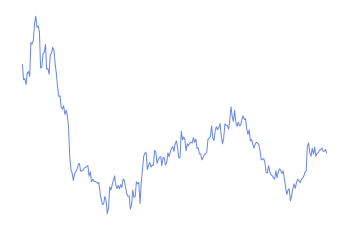

In [18]:
df_price=AStock.getStockDailyPriceByCode(code='002624.SZ',where=" and trade_date>20211127",fq='qfq')
#x_axis_data = df_price['trade_date']
y_axis_data = df_price['close']
# plot中参数的含义分别是横轴值，纵轴值，线的形状，颜色，透明度,线的宽度和标签
plt.plot(x_axis_data, y_axis_data,  color='#4169E1', alpha=0.8, linewidth=1, label='n')
# 显示标签，如果不加这句，即使在plot中加了label='一些数字'的参数，最终还是不会显示标签
#plt.xticks(())

frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
 
plt.show()
 